In [1]:
%load_ext tensorboard
import pandas as pd

data = pd.read_csv('fake reviews dataset.csv')
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


## Training a BERT Transformer Model

In [2]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow as tf

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the BERT model
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

2024-04-10 13:25:14.173894: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 13:25:14.196445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 13:25:14.641730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-10 13:25:15.801764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 13:25:15.802331: 

In [3]:

# Tokenize the texts
input_ids = []
attention_masks = []

for row in data.iterrows():
    text = row[1][3]
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Text to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'tf',     # Return TensorFlow tensors
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

y = data['label'].replace('CG', 1).replace('OR', 0).astype('int32').values

# Convert lists into tensors
input_ids = tf.concat(input_ids, 0)
attention_masks = tf.concat(attention_masks, 0)
labels = tf.convert_to_tensor(y)

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids, 'attention_mask': attention_masks}, labels))

# Calculate the number for training and testing
TOTAL_SIZE = len(labels)
TRAIN_SIZE = int(0.8 * TOTAL_SIZE)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

# Split the dataset into training and testing
train_dataset = dataset.take(TRAIN_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE)


/tmp/ipykernel_306383/3536513039.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[1][3]
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ciyfhx/miniforge3/envs/SC1015/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Train the model
model_bert.fit(train_dataset.shuffle(100).batch(16), epochs=3)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1712726764.243365  307073 service.cc:145] XLA service 0x7f58a4e78380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712726764.243399  307073 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-10 13:26:04.246612: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 13:26:04.257400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1712726764.285022  307073 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2022/2022 [==============================] - 367s 167ms/step - loss: 0.1088 - accuracy: 0.9578
Epoch 2/3
2022/2022 [==============================] - 297s 147ms/step - loss: 0.0348 - accuracy: 0.9870
Epoch 3/3
2022/2022 [==============================] - 299s 148ms/step - loss: 0.0174 - accuracy: 0.9941


## Evaluation scores for BERT Model

253/253 [==============================] - 28s 112ms/step
Precision: 0.9017
Recall: 0.9933
F1 Score: 0.9453
Accuracy: 0.9425


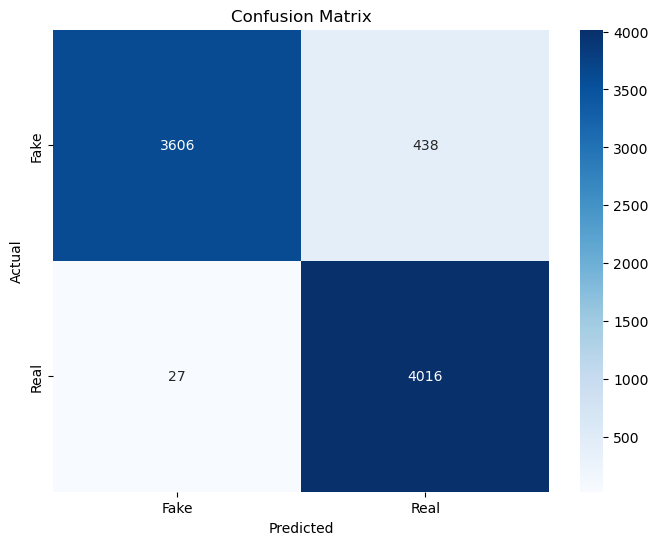

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_pred = model_bert.predict(test_dataset.batch(32))
y_pred_sigmoid = tf.keras.activations.sigmoid(y_pred.logits).numpy()

# Convert probabilities to binary predictions
y_pred_binary = [1 if p > np.mean(y_pred_sigmoid) else 0 for p in y_pred_sigmoid[:, 1]]
y_test = y[TRAIN_SIZE:]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Define labels
labels = ['Fake', 'Real']

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

# Print the evaluation scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve for BERT Model

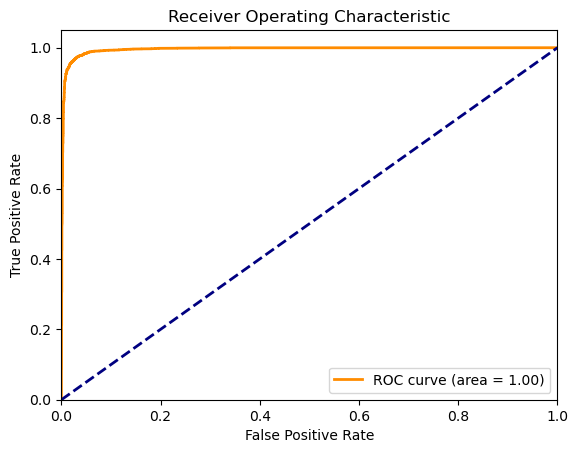

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_sigmoid[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Save BERT Model

In [11]:
model_bert.save_pretrained("./models/BERT/model_bert")
tokenizer.save_pretrained("./models/BERT/model_bert")

('./models/bert/model_bert/tokenizer_config.json',
 './models/bert/model_bert/special_tokens_map.json',
 './models/bert/model_bert/vocab.txt',
 './models/bert/model_bert/added_tokens.json')